In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

C:\Users\gianm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data():    
    data = pd.read_csv('dataset.csv')
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y

In [3]:
def build_model(trial, input_dim):
    model = Sequential()
    n_layers = trial.suggest_int("n_layers", 1, 5)

    # First Layer
    units = trial.suggest_int(f"n_units_i", 16, 256, step=16)
    model.add(Dense(units, activation="relu", input_dim=input_dim))  # input_dim specified
    dropout_rate = trial.suggest_float(f"dropout_rate", 0.0, 0.5)
    model.add(Dropout(dropout_rate))

    # Hidden Layers
    units_h = trial.suggest_int(f"n_units_h", 16, 256, step=16) 
    for i in range(n_layers):
        model.add(Dense(units_h, activation="relu"))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float("lr", 1e-4, 1e-2, log=True)),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


In [4]:
def objective(trial):
    X, y = load_data()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model(trial, input_dim=X_train.shape[1])
        model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    return np.mean(accuracies)

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)

[I 2025-01-15 10:44:53,768] A new study created in memory with name: no-name-2cbe347c-cb95-4808-801a-530759001698


306/306 [==============================] - 0s 1ms/step


[I 2025-01-15 10:46:07,225] Trial 0 finished with value: 0.8345480685740693 and parameters: {'n_layers': 5, 'n_units_i': 128, 'dropout_rate': 0.19292468195402535, 'n_units_h': 208, 'lr': 0.0003652996176928096}. Best is trial 0 with value: 0.8345480685740693.


306/306 [==============================] - 0s 628us/step


[I 2025-01-15 10:46:35,273] Trial 1 finished with value: 0.8359608261235859 and parameters: {'n_layers': 2, 'n_units_i': 176, 'dropout_rate': 0.3104394601144309, 'n_units_h': 48, 'lr': 0.002223572160169615}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 613us/step


[I 2025-01-15 10:47:30,096] Trial 2 finished with value: 0.831968345941117 and parameters: {'n_layers': 4, 'n_units_i': 128, 'dropout_rate': 0.4694890860214815, 'n_units_h': 112, 'lr': 0.005114036635053162}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 600us/step


[I 2025-01-15 10:48:15,611] Trial 3 finished with value: 0.834589062629292 and parameters: {'n_layers': 4, 'n_units_i': 240, 'dropout_rate': 0.08821330847662101, 'n_units_h': 80, 'lr': 0.00022886750563358738}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 648us/step


[I 2025-01-15 10:49:14,371] Trial 4 finished with value: 0.8353466362909499 and parameters: {'n_layers': 4, 'n_units_i': 256, 'dropout_rate': 0.40267832848399837, 'n_units_h': 176, 'lr': 0.0005037009991541479}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 582us/step


[I 2025-01-15 10:50:16,495] Trial 5 finished with value: 0.8328282674582195 and parameters: {'n_layers': 5, 'n_units_i': 128, 'dropout_rate': 0.3738653641727833, 'n_units_h': 112, 'lr': 0.00017029934950909528}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 644us/step


[I 2025-01-15 10:51:10,997] Trial 6 finished with value: 0.8341795601238738 and parameters: {'n_layers': 5, 'n_units_i': 128, 'dropout_rate': 0.007015931516059282, 'n_units_h': 96, 'lr': 0.0017351695536472025}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 589us/step


[I 2025-01-15 10:51:57,913] Trial 7 finished with value: 0.8341590830074809 and parameters: {'n_layers': 5, 'n_units_i': 64, 'dropout_rate': 0.3337771096433777, 'n_units_h': 80, 'lr': 0.0021540225767165094}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 648us/step


[I 2025-01-15 10:52:36,851] Trial 8 finished with value: 0.8356742198512084 and parameters: {'n_layers': 2, 'n_units_i': 240, 'dropout_rate': 0.10067257928031287, 'n_units_h': 112, 'lr': 0.0002760712861470855}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 567us/step


[I 2025-01-15 10:53:12,018] Trial 9 finished with value: 0.8348552127444542 and parameters: {'n_layers': 2, 'n_units_i': 112, 'dropout_rate': 0.17392389275806935, 'n_units_h': 160, 'lr': 0.0005119007749276978}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 557us/step


[I 2025-01-15 10:53:33,788] Trial 10 finished with value: 0.8352236708926236 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.26193674572871095, 'n_units_h': 32, 'lr': 0.007996565387598678}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 566us/step


[I 2025-01-15 10:53:58,361] Trial 11 finished with value: 0.8353261277357908 and parameters: {'n_layers': 2, 'n_units_i': 192, 'dropout_rate': 0.2758261954431929, 'n_units_h': 32, 'lr': 0.001178500403145186}. Best is trial 1 with value: 0.8359608261235859.


306/306 [==============================] - 0s 625us/step


[I 2025-01-15 10:54:40,926] Trial 12 finished with value: 0.8360017405339342 and parameters: {'n_layers': 2, 'n_units_i': 192, 'dropout_rate': 0.12202191215679135, 'n_units_h': 256, 'lr': 0.00011822233752861786}. Best is trial 12 with value: 0.8360017405339342.


306/306 [==============================] - 0s 582us/step


[I 2025-01-15 10:55:10,499] Trial 13 finished with value: 0.8363293806839718 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.15998800083411907, 'n_units_h': 256, 'lr': 0.003692798185242817}. Best is trial 13 with value: 0.8363293806839718.


306/306 [==============================] - 0s 538us/step


[I 2025-01-15 10:55:31,736] Trial 14 finished with value: 0.8285286975992268 and parameters: {'n_layers': 1, 'n_units_i': 16, 'dropout_rate': 0.1490056477398616, 'n_units_h': 256, 'lr': 0.00010054888681900647}. Best is trial 13 with value: 0.8363293806839718.


306/306 [==============================] - 0s 584us/step


[I 2025-01-15 10:56:00,959] Trial 15 finished with value: 0.834773264456446 and parameters: {'n_layers': 1, 'n_units_i': 176, 'dropout_rate': 0.015399179478040648, 'n_units_h': 256, 'lr': 0.00391831549798094}. Best is trial 13 with value: 0.8363293806839718.


306/306 [==============================] - 0s 774us/step


[I 2025-01-15 10:56:53,741] Trial 16 finished with value: 0.8358174925965898 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.08907504850305506, 'n_units_h': 224, 'lr': 0.0008534968259919388}. Best is trial 13 with value: 0.8363293806839718.


306/306 [==============================] - 0s 692us/step


[I 2025-01-15 10:57:40,530] Trial 17 finished with value: 0.8338110873042801 and parameters: {'n_layers': 3, 'n_units_i': 80, 'dropout_rate': 0.21193287254912782, 'n_units_h': 208, 'lr': 0.00010277201504961883}. Best is trial 13 with value: 0.8363293806839718.


306/306 [==============================] - 0s 631us/step


[I 2025-01-15 10:58:10,627] Trial 18 finished with value: 0.8362679681980533 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.13007388203060266, 'n_units_h': 224, 'lr': 0.0036344881481742536}. Best is trial 13 with value: 0.8363293806839718.


306/306 [==============================] - 0s 617us/step


[I 2025-01-15 10:58:38,590] Trial 19 finished with value: 0.8364317327312516 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.2154511913903191, 'n_units_h': 160, 'lr': 0.0043002342149312525}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 580us/step


[I 2025-01-15 10:59:05,076] Trial 20 finished with value: 0.8349986154367359 and parameters: {'n_layers': 1, 'n_units_i': 160, 'dropout_rate': 0.05010344700699415, 'n_units_h': 160, 'lr': 0.009337543773638393}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 595us/step


[I 2025-01-15 10:59:34,466] Trial 21 finished with value: 0.835387577948229 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.2103921580344166, 'n_units_h': 224, 'lr': 0.00403920086882619}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 587us/step


[I 2025-01-15 11:00:03,642] Trial 22 finished with value: 0.8353056988255064 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.1555688631360475, 'n_units_h': 192, 'lr': 0.005918052359769194}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 608us/step


[I 2025-01-15 11:00:30,996] Trial 23 finished with value: 0.8362474491633055 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.23991412200004597, 'n_units_h': 144, 'lr': 0.003081473071646038}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 710us/step


[I 2025-01-15 11:01:12,350] Trial 24 finished with value: 0.8354489485157925 and parameters: {'n_layers': 2, 'n_units_i': 224, 'dropout_rate': 0.1310067637201084, 'n_units_h': 224, 'lr': 0.002986824457822367}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 571us/step


[I 2025-01-15 11:01:40,246] Trial 25 finished with value: 0.8354080362013621 and parameters: {'n_layers': 1, 'n_units_i': 160, 'dropout_rate': 0.0613947767798389, 'n_units_h': 240, 'lr': 0.0013808244551533667}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 651us/step


[I 2025-01-15 11:02:27,916] Trial 26 finished with value: 0.8347118624501162 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.21938946702717727, 'n_units_h': 192, 'lr': 0.006391347153317468}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 597us/step


[I 2025-01-15 11:03:04,160] Trial 27 finished with value: 0.8354898734057296 and parameters: {'n_layers': 2, 'n_units_i': 160, 'dropout_rate': 0.2821250331282259, 'n_units_h': 192, 'lr': 0.0008243250228037017}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 566us/step


[I 2025-01-15 11:03:33,793] Trial 28 finished with value: 0.8355717818713007 and parameters: {'n_layers': 1, 'n_units_i': 240, 'dropout_rate': 0.17645710366246037, 'n_units_h': 240, 'lr': 0.0027795334263338942}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 813us/step


[I 2025-01-15 11:04:24,886] Trial 29 finished with value: 0.8341795643157092 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.18360670736909188, 'n_units_h': 208, 'lr': 0.0043088588278068765}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 612us/step


[I 2025-01-15 11:04:52,311] Trial 30 finished with value: 0.8357970301516211 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.05822409896441742, 'n_units_h': 144, 'lr': 0.0017031150045995803}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 634us/step


[I 2025-01-15 11:05:19,977] Trial 31 finished with value: 0.8353466300031966 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.23848660919222903, 'n_units_h': 144, 'lr': 0.0033093378164506934}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 600us/step


[I 2025-01-15 11:05:45,426] Trial 32 finished with value: 0.835878932329439 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.31304863031719915, 'n_units_h': 128, 'lr': 0.0023982092223760547}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 666us/step


[I 2025-01-15 11:06:22,488] Trial 33 finished with value: 0.8337905892287099 and parameters: {'n_layers': 2, 'n_units_i': 240, 'dropout_rate': 0.23615841166557122, 'n_units_h': 160, 'lr': 0.007159418279768242}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 564us/step


[I 2025-01-15 11:06:46,839] Trial 34 finished with value: 0.8355921856305724 and parameters: {'n_layers': 1, 'n_units_i': 176, 'dropout_rate': 0.12558932842327444, 'n_units_h': 128, 'lr': 0.005327030086686165}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 564us/step


[I 2025-01-15 11:07:15,996] Trial 35 finished with value: 0.8360427115340616 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.19705080608479214, 'n_units_h': 176, 'lr': 0.004634804949948266}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 695us/step


[I 2025-01-15 11:07:57,296] Trial 36 finished with value: 0.8356741506859227 and parameters: {'n_layers': 2, 'n_units_i': 208, 'dropout_rate': 0.48251708683211747, 'n_units_h': 240, 'lr': 0.0018089327329247147}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 603us/step


[I 2025-01-15 11:08:25,251] Trial 37 finished with value: 0.8347527789563822 and parameters: {'n_layers': 1, 'n_units_i': 240, 'dropout_rate': 0.36392364250092446, 'n_units_h': 176, 'lr': 0.0034259650338020666}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 557us/step


[I 2025-01-15 11:08:52,800] Trial 38 finished with value: 0.8205237233157184 and parameters: {'n_layers': 2, 'n_units_i': 144, 'dropout_rate': 0.4411989804911969, 'n_units_h': 64, 'lr': 0.009582027180075722}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 603us/step


[I 2025-01-15 11:09:49,321] Trial 39 finished with value: 0.8354489715708878 and parameters: {'n_layers': 4, 'n_units_i': 192, 'dropout_rate': 0.312311452186867, 'n_units_h': 112, 'lr': 0.0021766744463451405}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 630us/step


[I 2025-01-15 11:10:25,881] Trial 40 finished with value: 0.8348142647994219 and parameters: {'n_layers': 2, 'n_units_i': 256, 'dropout_rate': 0.15078686393327662, 'n_units_h': 96, 'lr': 0.002686990452374162}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 582us/step


[I 2025-01-15 11:10:54,791] Trial 41 finished with value: 0.8360631551157706 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.19657717570921024, 'n_units_h': 176, 'lr': 0.004724209198350269}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 626us/step


[I 2025-01-15 11:11:23,659] Trial 42 finished with value: 0.8354899299955088 and parameters: {'n_layers': 1, 'n_units_i': 240, 'dropout_rate': 0.2516601354786502, 'n_units_h': 176, 'lr': 0.005168837457653438}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 620us/step


[I 2025-01-15 11:11:50,839] Trial 43 finished with value: 0.8356946487614929 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.16509200160773646, 'n_units_h': 144, 'lr': 0.0038956526136040164}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 541us/step


[I 2025-01-15 11:12:18,702] Trial 44 finished with value: 0.8331558300593003 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.19546338399753677, 'n_units_h': 160, 'lr': 0.007823457551737904}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 580us/step


[I 2025-01-15 11:12:47,785] Trial 45 finished with value: 0.83434339172644 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.2797687254518736, 'n_units_h': 208, 'lr': 0.005966714319766819}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 610us/step


[I 2025-01-15 11:13:17,850] Trial 46 finished with value: 0.8355512816998129 and parameters: {'n_layers': 2, 'n_units_i': 208, 'dropout_rate': 0.10627032555819403, 'n_units_h': 128, 'lr': 0.0033363672921716816}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 594us/step


[I 2025-01-15 11:13:47,620] Trial 47 finished with value: 0.8357356008983606 and parameters: {'n_layers': 1, 'n_units_i': 240, 'dropout_rate': 0.2201315101728442, 'n_units_h': 240, 'lr': 0.0014332683639104206}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 584us/step


[I 2025-01-15 11:14:12,100] Trial 48 finished with value: 0.8355922610836114 and parameters: {'n_layers': 4, 'n_units_i': 176, 'dropout_rate': 0.1393067754615034, 'n_units_h': 16, 'lr': 0.0006432827624822609}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 603us/step


[I 2025-01-15 11:14:48,782] Trial 49 finished with value: 0.8356741737410178 and parameters: {'n_layers': 2, 'n_units_i': 96, 'dropout_rate': 0.2628199770363815, 'n_units_h': 192, 'lr': 0.0021465946040151117}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 582us/step


[I 2025-01-15 11:15:17,917] Trial 50 finished with value: 0.8364112053128331 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.10947564143080356, 'n_units_h': 256, 'lr': 0.004874708320156362}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 577us/step


[I 2025-01-15 11:15:46,362] Trial 51 finished with value: 0.8362269301285578 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.10736301602630632, 'n_units_h': 256, 'lr': 0.004710692878536952}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 544us/step


[I 2025-01-15 11:16:15,315] Trial 52 finished with value: 0.8355513026589902 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.08340651539586832, 'n_units_h': 256, 'lr': 0.007254344526702331}. Best is trial 19 with value: 0.8364317327312516.


306/306 [==============================] - 0s 576us/step


[I 2025-01-15 11:16:42,643] Trial 53 finished with value: 0.8364521867925492 and parameters: {'n_layers': 1, 'n_units_i': 144, 'dropout_rate': 0.0779782294758222, 'n_units_h': 256, 'lr': 0.0037610606816747107}. Best is trial 53 with value: 0.8364521867925492.


306/306 [==============================] - 0s 564us/step


[I 2025-01-15 11:17:08,687] Trial 54 finished with value: 0.8343638814183393 and parameters: {'n_layers': 1, 'n_units_i': 144, 'dropout_rate': 0.021261327811424563, 'n_units_h': 224, 'lr': 0.00359759406436318}. Best is trial 53 with value: 0.8364521867925492.


306/306 [==============================] - 0s 523us/step


[I 2025-01-15 11:17:37,736] Trial 55 finished with value: 0.836697905901509 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.07299992683795026, 'n_units_h': 240, 'lr': 0.002612903665781683}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 556us/step


[I 2025-01-15 11:18:06,198] Trial 56 finished with value: 0.8358380430701036 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.0773899672474202, 'n_units_h': 240, 'lr': 0.0025866896339067956}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 582us/step


[I 2025-01-15 11:18:43,210] Trial 57 finished with value: 0.8351828130720544 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.0675552329300888, 'n_units_h': 256, 'lr': 0.0019520116044495844}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 556us/step


[I 2025-01-15 11:19:11,928] Trial 58 finished with value: 0.8352237400579094 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.028864690606129978, 'n_units_h': 224, 'lr': 0.0002593177553503967}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 562us/step


[I 2025-01-15 11:19:37,682] Trial 59 finished with value: 0.8361450635813416 and parameters: {'n_layers': 1, 'n_units_i': 128, 'dropout_rate': 0.12091313472231015, 'n_units_h': 240, 'lr': 0.00035569595647458703}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 615us/step


[I 2025-01-15 11:20:14,235] Trial 60 finished with value: 0.8347937457646741 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.09927167091447833, 'n_units_h': 256, 'lr': 0.005777447560593905}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 561us/step


[I 2025-01-15 11:20:39,766] Trial 61 finished with value: 0.8344866833350814 and parameters: {'n_layers': 1, 'n_units_i': 96, 'dropout_rate': 0.040011916915673684, 'n_units_h': 208, 'lr': 0.003090920216300122}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 576us/step


[I 2025-01-15 11:21:06,676] Trial 62 finished with value: 0.8355308318303507 and parameters: {'n_layers': 1, 'n_units_i': 144, 'dropout_rate': 0.002384077696079581, 'n_units_h': 256, 'lr': 0.004220332496877755}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 559us/step


[I 2025-01-15 11:21:34,084] Trial 63 finished with value: 0.8358788883151664 and parameters: {'n_layers': 1, 'n_units_i': 176, 'dropout_rate': 0.13989653896753482, 'n_units_h': 240, 'lr': 0.0038156018250031717}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 531us/step


[I 2025-01-15 11:22:00,704] Trial 64 finished with value: 0.8343842788898577 and parameters: {'n_layers': 1, 'n_units_i': 160, 'dropout_rate': 0.17103171651052912, 'n_units_h': 224, 'lr': 0.006631912024540758}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 548us/step


[I 2025-01-15 11:22:30,074] Trial 65 finished with value: 0.8362474093408683 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.11539464226146862, 'n_units_h': 256, 'lr': 0.0028774741152870487}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 620us/step


[I 2025-01-15 11:22:58,747] Trial 66 finished with value: 0.835100908798319 and parameters: {'n_layers': 1, 'n_units_i': 208, 'dropout_rate': 0.04464402843648689, 'n_units_h': 240, 'lr': 0.00146045421474594}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 807us/step


[I 2025-01-15 11:23:54,695] Trial 67 finished with value: 0.8349986154367361 and parameters: {'n_layers': 4, 'n_units_i': 32, 'dropout_rate': 0.09200131833616551, 'n_units_h': 224, 'lr': 0.0011767338408336357}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 941us/step


[I 2025-01-15 11:25:10,079] Trial 68 finished with value: 0.8309036867947709 and parameters: {'n_layers': 5, 'n_units_i': 224, 'dropout_rate': 0.23185459683402115, 'n_units_h': 224, 'lr': 0.005498147101513298}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 1ms/step


[I 2025-01-15 11:25:36,866] Trial 69 finished with value: 0.8354899195159202 and parameters: {'n_layers': 1, 'n_units_i': 96, 'dropout_rate': 0.07178753047843178, 'n_units_h': 96, 'lr': 0.002467532011425331}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 615us/step


[I 2025-01-15 11:26:16,613] Trial 70 finished with value: 0.8358789260416856 and parameters: {'n_layers': 2, 'n_units_i': 128, 'dropout_rate': 0.15733719318830236, 'n_units_h': 256, 'lr': 0.0031918623724096085}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 561us/step


[I 2025-01-15 11:26:47,257] Trial 71 finished with value: 0.834670887258153 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.11533413553512145, 'n_units_h': 256, 'lr': 0.00289265724534415}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 551us/step


[I 2025-01-15 11:27:12,858] Trial 72 finished with value: 0.835285202845854 and parameters: {'n_layers': 1, 'n_units_i': 80, 'dropout_rate': 0.12941831413559685, 'n_units_h': 240, 'lr': 0.004495769767393219}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 556us/step


[I 2025-01-15 11:27:42,622] Trial 73 finished with value: 0.8360631236770043 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.18492023104990718, 'n_units_h': 256, 'lr': 0.003954828349414449}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 549us/step


[I 2025-01-15 11:28:12,382] Trial 74 finished with value: 0.8356332153163969 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.14421239855374657, 'n_units_h': 240, 'lr': 0.00016754538443357138}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 587us/step


[I 2025-01-15 11:28:40,957] Trial 75 finished with value: 0.8361041533628288 and parameters: {'n_layers': 1, 'n_units_i': 160, 'dropout_rate': 0.2945063211120903, 'n_units_h': 256, 'lr': 0.002788833591875226}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 615us/step


[I 2025-01-15 11:29:09,949] Trial 76 finished with value: 0.8361246388628926 and parameters: {'n_layers': 1, 'n_units_i': 208, 'dropout_rate': 0.08647501662275503, 'n_units_h': 208, 'lr': 0.001999020054266172}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 551us/step


[I 2025-01-15 11:29:35,790] Trial 77 finished with value: 0.8349166755323989 and parameters: {'n_layers': 1, 'n_units_i': 80, 'dropout_rate': 0.11457277069041254, 'n_units_h': 240, 'lr': 0.003575297915464088}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 603us/step


[I 2025-01-15 11:30:13,648] Trial 78 finished with value: 0.833606284701586 and parameters: {'n_layers': 2, 'n_units_i': 128, 'dropout_rate': 0.2104800829890101, 'n_units_h': 240, 'lr': 0.008643609661686778}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 605us/step


[I 2025-01-15 11:30:42,839] Trial 79 finished with value: 0.8361655553691586 and parameters: {'n_layers': 1, 'n_units_i': 240, 'dropout_rate': 0.04947640928784426, 'n_units_h': 112, 'lr': 0.0016313306012550339}. Best is trial 55 with value: 0.836697905901509.


306/306 [==============================] - 0s 554us/step


[I 2025-01-15 11:31:07,976] Trial 80 finished with value: 0.837045993825091 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.15994194841579412, 'n_units_h': 80, 'lr': 0.0023084566940440483}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 572us/step


[I 2025-01-15 11:31:32,971] Trial 81 finished with value: 0.8361450782527658 and parameters: {'n_layers': 1, 'n_units_i': 208, 'dropout_rate': 0.1637733605363174, 'n_units_h': 80, 'lr': 0.0023321959371152986}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 554us/step


[I 2025-01-15 11:31:56,019] Trial 82 finished with value: 0.8358174884047542 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.18086875266074615, 'n_units_h': 48, 'lr': 0.0030735964567522567}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 557us/step


[I 2025-01-15 11:32:21,873] Trial 83 finished with value: 0.8342614685894448 and parameters: {'n_layers': 1, 'n_units_i': 240, 'dropout_rate': 0.10073327695363499, 'n_units_h': 128, 'lr': 0.005043184934324038}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 600us/step


[I 2025-01-15 11:32:47,958] Trial 84 finished with value: 0.8360836888219426 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.12763110476584216, 'n_units_h': 144, 'lr': 0.0026069024916940665}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 546us/step


[I 2025-01-15 11:33:19,845] Trial 85 finished with value: 0.8355513823038645 and parameters: {'n_layers': 3, 'n_units_i': 144, 'dropout_rate': 0.15241384576394956, 'n_units_h': 64, 'lr': 0.0035582850604582443}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 585us/step


[I 2025-01-15 11:33:49,098] Trial 86 finished with value: 0.8351213942983827 and parameters: {'n_layers': 1, 'n_units_i': 176, 'dropout_rate': 0.22653208597566388, 'n_units_h': 256, 'lr': 0.0040607205757665354}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 613us/step


[I 2025-01-15 11:34:16,946] Trial 87 finished with value: 0.8361860471569755 and parameters: {'n_layers': 1, 'n_units_i': 240, 'dropout_rate': 0.25081118728702945, 'n_units_h': 160, 'lr': 0.0022148343294176895}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 525us/step


[I 2025-01-15 11:34:44,864] Trial 88 finished with value: 0.8351623799699345 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.26683256160943447, 'n_units_h': 224, 'lr': 0.00468587858206299}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 625us/step


[I 2025-01-15 11:35:14,791] Trial 89 finished with value: 0.8353670107073731 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.20639323048129946, 'n_units_h': 112, 'lr': 0.0029507469684653185}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 612us/step


[I 2025-01-15 11:35:44,522] Trial 90 finished with value: 0.8355513047549079 and parameters: {'n_layers': 1, 'n_units_i': 208, 'dropout_rate': 0.06274739183055053, 'n_units_h': 240, 'lr': 0.0018469342523757032}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 592us/step


[I 2025-01-15 11:36:14,418] Trial 91 finished with value: 0.8353466132358548 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.09953841996191798, 'n_units_h': 256, 'lr': 0.004992458266084711}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 556us/step


[I 2025-01-15 11:36:44,202] Trial 92 finished with value: 0.8342614602057739 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.11083303617065615, 'n_units_h': 256, 'lr': 0.006410267291030634}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 544us/step


[I 2025-01-15 11:37:12,381] Trial 93 finished with value: 0.8352032755170231 and parameters: {'n_layers': 1, 'n_units_i': 176, 'dropout_rate': 0.13899087794383527, 'n_units_h': 256, 'lr': 0.0042808511672095114}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 664us/step


[I 2025-01-15 11:37:42,470] Trial 94 finished with value: 0.8349371149222721 and parameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.08381646561070347, 'n_units_h': 256, 'lr': 0.0033161467405962764}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 626us/step


[I 2025-01-15 11:38:10,915] Trial 95 finished with value: 0.8361041575546642 and parameters: {'n_layers': 1, 'n_units_i': 208, 'dropout_rate': 0.07370742298392474, 'n_units_h': 240, 'lr': 0.005890910676122247}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 543us/step


[I 2025-01-15 11:38:38,222] Trial 96 finished with value: 0.8359198886581425 and parameters: {'n_layers': 1, 'n_units_i': 160, 'dropout_rate': 0.13446605028934724, 'n_units_h': 224, 'lr': 0.003629589128254589}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 571us/step


[I 2025-01-15 11:39:03,351] Trial 97 finished with value: 0.836288411779762 and parameters: {'n_layers': 1, 'n_units_i': 192, 'dropout_rate': 0.03324891484602718, 'n_units_h': 144, 'lr': 0.004598325838401019}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 549us/step


[I 2025-01-15 11:39:26,835] Trial 98 finished with value: 0.8360427429728279 and parameters: {'n_layers': 1, 'n_units_i': 128, 'dropout_rate': 0.012666402926809536, 'n_units_h': 144, 'lr': 0.0026076818532348753}. Best is trial 80 with value: 0.837045993825091.


306/306 [==============================] - 0s 562us/step


[I 2025-01-15 11:39:58,116] Trial 99 finished with value: 0.8351418986617063 and parameters: {'n_layers': 2, 'n_units_i': 96, 'dropout_rate': 0.023312145400314822, 'n_units_h': 144, 'lr': 0.004418656257830434}. Best is trial 80 with value: 0.837045993825091.


Best hyperparameters: {'n_layers': 1, 'n_units_i': 224, 'dropout_rate': 0.15994194841579412, 'n_units_h': 80, 'lr': 0.0023084566940440483}


In [6]:
import optuna.visualization as vis
fig = vis.plot_optimization_history(study)
fig.show()

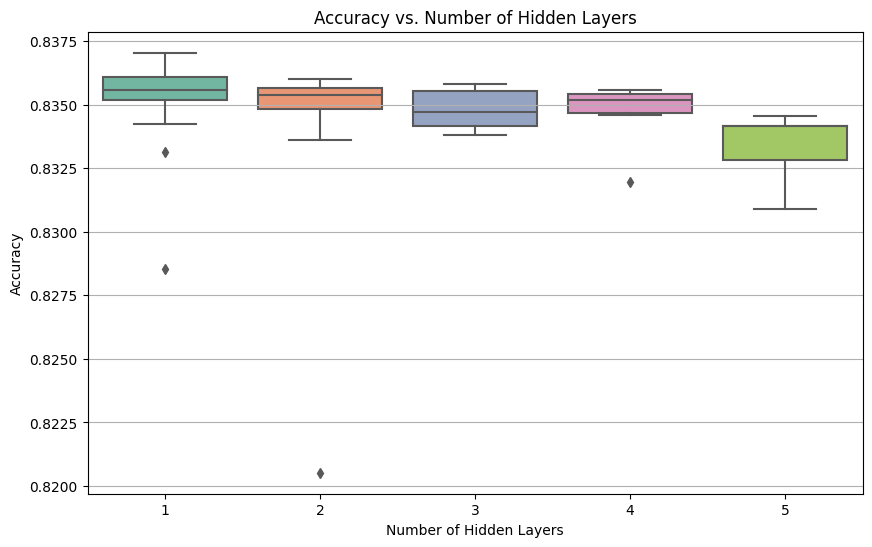

In [7]:


n_layers = [trial.params['n_layers'] for trial in study.trials]
accuracies = [trial.value for trial in study.trials]


data = pd.DataFrame({'n_layers': n_layers, 'accuracy': accuracies})
plt.figure(figsize=(10, 6))
sns.boxplot(x='n_layers', y='accuracy', data=data, palette='Set2')


plt.title('Accuracy vs. Number of Hidden Layers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.grid(axis='y') 
plt.show()

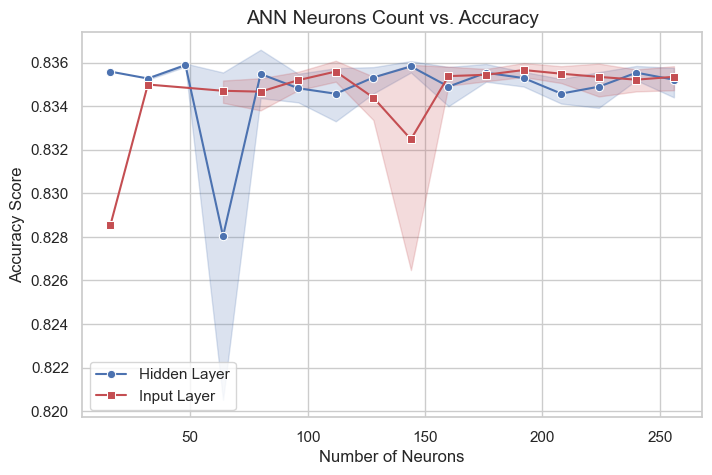

In [8]:
n_units_i = [trial.params['n_units_i'] for trial in study.trials]
n_units_h = [trial.params['n_units_h'] for trial in study.trials]
accuracies = [trial.value for trial in study.trials if trial.value is not None]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=n_units_h, y=accuracies, marker='o', color='b', label='Hidden Layer')
sns.lineplot(x=n_units_i, y=accuracies, marker='s', color='r', label='Input Layer')
plt.title('ANN Neurons Count vs. Accuracy', fontsize=14)
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.show()

In [9]:
def build_best_model(study, input_dim):
    model = Sequential()
    X, _ = load_data()
    model = Sequential()
    n_layers = study.best_params['n_layers']

    # Input Layer
    units = study.best_params['n_units_i']
    model.add(Dense(units, activation="relu", input_dim=input_dim))  # input_dim specified
    dropout_rate = study.best_params['dropout_rate']
    model.add(Dropout(dropout_rate))

    # Hidden Layers
    units_h = study.best_params['n_units_h']
    for i in range(n_layers):
        model.add(Dense(units_h, activation="relu"))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=study.best_params['lr']),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:
X, y = load_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = build_best_model(study, X_train.shape[1])
    model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)


print(accuracy_score(y_test, y_pred))
joblib.dump(model, 'ann_model.joblib')

model_pkl_file = "ann_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)
model.save('ann_model.h5')

306/306 [==============================] - 0s 551us/step
0.8341523341523341
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2025-01-15 11:40:25         2593
metadata.json                                  2025-01-15 11:40:25           64
variables.h5                                   2025-01-15 11:40:25       307328
Keras we

In [14]:
#model.save('ann_model.h5')
test,_ = load_data()
print(test)


       Unnamed: 0   age  educational-num  gender  capital-gain  capital-loss  \
0               0  25.0              7.0       1           0.0             0   
1               1  38.0              9.0       1           0.0             0   
2               2  28.0             12.0       1           0.0             0   
3               3  44.0             10.0       1        7688.0             0   
4               4  18.0             10.0       0           0.0             0   
...           ...   ...              ...     ...           ...           ...   
48837       48837  27.0             12.0       0           0.0             0   
48838       48838  40.0              9.0       1           0.0             0   
48839       48839  58.0              9.0       0           0.0             0   
48840       48840  22.0              9.0       1           0.0             0   
48841       48841  52.0              9.0       0       15024.0             0   

       hours-per-week  native-country  